# UCI-HAR — HMM (Forward/Brute-Force) vs SVM + Flask\n

# Setup و بارگذاری دیتاست

In [1]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC

import sys
sys.path.append('..'); sys.path.append('../src')

from src.data import download_har, load_har_features, build_sequences
from src.hmm_utils import brute_force_p_observation, forward_p_observation, mk_tiny_hmm

DATA_ROOT = '../data'
os.makedirs(DATA_ROOT, exist_ok=True)

try:
    ds_dir = download_har(DATA_ROOT)   # اگر اینترنت نبود، except اجرا می‌شود
except Exception:
    ds_dir = os.path.join(DATA_ROOT, 'UCI HAR Dataset')

X_train, y_train, X_test, y_test, subjects, label_map = load_har_features(ds_dir)
label_name = lambda i: label_map[int(i)]
print('Train:', X_train.shape, '| Test:', X_test.shape)


Train: (7767, 561) | Test: (3162, 561)


# EDA (توزیع کلاس‌ها)

,label_id,label,train_count,test_count
0,1,WALKING,1226,496
1,2,WALKING_UPSTAIRS,1073,471
2,3,WALKING_DOWNSTAIRS,987,420
3,4,SITTING,1293,508
4,5,STANDING,1423,556
5,6,LAYING,1413,545
6,7,STAND_TO_SIT,47,23
7,8,SIT_TO_STAND,23,10
8,9,SIT_TO_LIE,75,32
9,10,LIE_TO_SIT,60,25


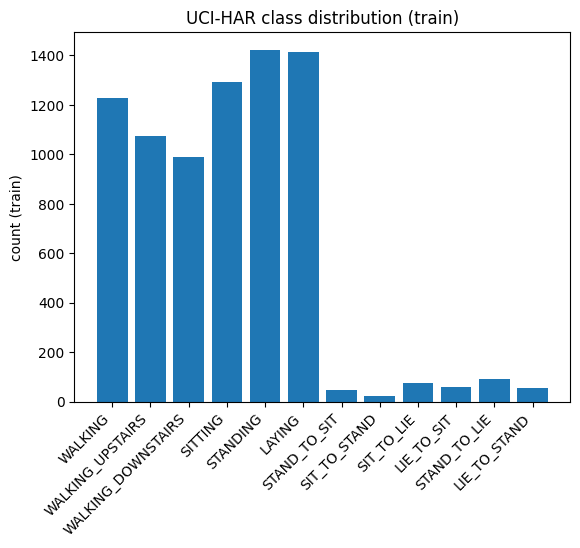

In [2]:
train_counts = y_train.value_counts().sort_index()
test_counts  = y_test.value_counts().sort_index()

eda_df = pd.DataFrame({
    'label_id': train_counts.index,
    'label': [label_name(i) for i in train_counts.index],
    'train_count': train_counts.values,
    'test_count': test_counts.reindex(train_counts.index).values
})
display(eda_df)

plt.figure()
plt.bar(eda_df['label'], eda_df['train_count'])
plt.xticks(rotation=45, ha='right'); plt.ylabel('count (train)')
plt.title('UCI-HAR class distribution (train)')
plt.show()


# 
𝑃
(
𝑂
∣
𝜆
)
P(O∣λ) با Brute-Force و Forward

In [3]:
O, pi, A, means, covs = mk_tiny_hmm(seed=42)

p_brute   = brute_force_p_observation(O, pi, A, means, covs)
p_forward = forward_p_observation(O, pi, A, means, covs, log=False)
logp_fwd  = forward_p_observation(O, pi, A, means, covs, log=True)

print('Brute-Force  P(O|λ) =', p_brute)
print('Forward      P(O|λ) =', p_forward)
print('Forward  log P(O|λ) =', logp_fwd)
if p_brute > 0:
    print('Relative error:', abs(p_brute - p_forward)/p_brute)


Brute-Force  P(O|λ) = 0.0004629062949903649
Forward      P(O|λ) = 2160.2644224590067
Forward  log P(O|λ) = 7.677985910990858
Relative error: 4666741.374942149


# SVM (baseline ویژگی‌های ۵۶۱تایی)

In [4]:
scaler = StandardScaler()
Xtr = scaler.fit_transform(X_train.values)
Xte = scaler.transform(X_test.values)

svm = SVC(kernel='rbf', C=10, gamma='scale')
svm.fit(Xtr, y_train)

pred_svm = svm.predict(Xte)
acc_svm = accuracy_score(y_test, pred_svm)
print(f'SVM accuracy: {acc_svm:.4f}')
print(classification_report(y_test, pred_svm, target_names=[label_name(i) for i in sorted(label_map)]))
cm_svm = confusion_matrix(y_test, pred_svm, labels=sorted(label_map))
cm_svm


SVM accuracy: 0.9447
                    precision    recall  f1-score   support

           WALKING       0.96      0.98      0.97       496
  WALKING_UPSTAIRS       0.92      0.97      0.95       471
WALKING_DOWNSTAIRS       0.97      0.90      0.94       420
           SITTING       0.96      0.91      0.93       508
          STANDING       0.93      0.97      0.95       556
            LAYING       1.00      1.00      1.00       545
      STAND_TO_SIT       0.89      0.74      0.81        23
      SIT_TO_STAND       0.90      0.90      0.90        10
        SIT_TO_LIE       0.66      0.66      0.66        32
        LIE_TO_SIT       0.75      0.84      0.79        25
      STAND_TO_LIE       0.72      0.73      0.73        49
      LIE_TO_STAND       0.80      0.59      0.68        27

          accuracy                           0.94      3162
         macro avg       0.87      0.85      0.86      3162
      weighted avg       0.95      0.94      0.94      3162



array([[485,   4,   7,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 13, 456,   1,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  9,  31, 380,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 463,  42,   1,   1,   1,   0,   0,   0,   0],
       [  0,   0,   0,  17, 539,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 544,   0,   0,   0,   0,   1,   0],
       [  0,   2,   0,   2,   1,   0,  17,   0,   0,   0,   1,   0],
       [  0,   0,   1,   0,   0,   0,   0,   9,   0,   0,   0,   0],
       [  0,   0,   2,   0,   0,   0,   0,   0,  21,   0,   9,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  21,   0,   4],
       [  0,   0,   0,   1,   0,   1,   0,   0,  11,   0,  36,   0],
       [  0,   0,   1,   0,   0,   0,   0,   0,   0,   7,   3,  16]])

# روش Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300, random_state=0, n_jobs=-1)
rf.fit(X_train.values, y_train)        # روی دادهٔ خام، بدون اسکیل
pred_rf = rf.predict(X_test.values)
acc_rf  = accuracy_score(y_test, pred_rf)
print(f'RF accuracy: {acc_rf:.4f}')

# گزارش + ماتریس (با لیبل‌های حاضر؛ اگر خواستی همه‌ی کلاس‌ها را بده)
labels_present = sorted(set(y_test) | set(pred_rf))
names_present  = [label_map[i] for i in labels_present]
print(classification_report(y_test, pred_rf,
                            labels=labels_present,
                            target_names=names_present,
                            zero_division=0))
cm_rf = confusion_matrix(y_test, pred_rf, labels=labels_present)
cm_rf


RF accuracy: 0.9130
                    precision    recall  f1-score   support

           WALKING       0.89      0.97      0.93       496
  WALKING_UPSTAIRS       0.89      0.91      0.90       471
WALKING_DOWNSTAIRS       0.95      0.85      0.90       420
           SITTING       0.90      0.89      0.90       508
          STANDING       0.90      0.92      0.91       556
            LAYING       1.00      1.00      1.00       545
      STAND_TO_SIT       0.72      0.78      0.75        23
      SIT_TO_STAND       0.90      0.90      0.90        10
        SIT_TO_LIE       0.68      0.78      0.72        32
        LIE_TO_SIT       0.71      0.68      0.69        25
      STAND_TO_LIE       0.74      0.59      0.66        49
      LIE_TO_STAND       0.70      0.59      0.64        27

          accuracy                           0.91      3162
         macro avg       0.83      0.82      0.83      3162
      weighted avg       0.91      0.91      0.91      3162



array([[480,   4,  12,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 35, 429,   7,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 20,  44, 356,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 453,  54,   0,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0,  44, 511,   0,   1,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0, 544,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0,   2,   0,   0,  18,   1,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   1,   9,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  25,   0,   7,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1,  17,   0,   7],
       [  3,   1,   0,   2,   0,   0,   3,   0,  11,   0,  29,   0],
       [  0,   1,   0,   0,   0,   0,   1,   0,   0,   7,   2,  16]])

#  HMM (مدل کلاس‌به‌کلاس، تصمیم با بیشینهٔ log-likelihood)

In [ ]:
from hmmlearn.hmm import GaussianHMM

train_seqs = build_sequences(X_train, y_train, subjects['train'], max_len=25)
test_seqs  = build_sequences(X_test,  y_test,  subjects['test'],  max_len=25)

class_models = {}
for act_id in sorted(set(y_train)):
    seqs = [X for (X,y) in train_seqs if y==act_id]
    if not seqs: 
        continue
    lengths = [len(s) for s in seqs[:50]]    # برای سرعت
    data    = np.vstack(seqs[:50])
    m = GaussianHMM(
        n_components=3, covariance_type='diag',
        n_iter=60, tol=1e-2, random_state=0,
        startprob_prior=1.1, transmat_prior=1.1
    )
    m.fit(data, lengths)
    class_models[act_id] = m

y_true, y_pred = [], []
for X_seq, ylab in test_seqs:
    best_cls, best_score = None, -1e18
    for act_id, model in class_models.items():
        try: score = model.score(X_seq)
        except: score = -1e-18
        if score > best_score: best_score, best_cls = score, act_id
    y_true.append(ylab); y_pred.append(best_cls)

acc_hmm = accuracy_score(y_true, y_pred)
print(f'HMM (sequence-level) accuracy: {acc_hmm:.4f}')

# گزارش فقط روی کلاس‌هایی که واقعاً در y_true یا y_pred حضور دارند
labels_present = sorted(set(y_true) | set(y_pred))
names_present  = [label_name(i) for i in labels_present]

print(classification_report(
    y_true, y_pred,
    labels=labels_present,
    target_names=names_present,
    zero_division=0
))
cm_hmm = confusion_matrix(y_true, y_pred, labels=labels_present)
cm_hmm





Model is not converging.  Current: 290507.12044593965 is not greater than 290507.1322250297. Delta is -0.011779090040363371
Model is not converging.  Current: 1521870.0001339484 is not greater than 1522008.2888542807. Delta is -138.28872033231892
Model is not converging.  Current: 1423209.6774504003 is not greater than 1423255.5784665747. Delta is -45.901016174349934
Model is not converging.  Current: 1447523.6911821973 is not greater than 1447571.4128161776. Delta is -47.721633980283514
Model is not converging.  Current: 21359.688767688072 is not greater than 21359.688767703006. Delta is -1.4933903003111482e-08


HMM (sequence-level) accuracy: 0.8966
                    precision    recall  f1-score   support

           WALKING       0.91      0.87      0.89        23
  WALKING_UPSTAIRS       0.87      0.95      0.91        21
WALKING_DOWNSTAIRS       0.84      0.80      0.82        20
           SITTING       0.91      0.91      0.91        23
          STANDING       0.92      0.96      0.94        25
            LAYING       1.00      1.00      1.00        24
      STAND_TO_SIT       0.00      0.00      0.00         1
        SIT_TO_LIE       0.00      0.00      0.00         1
      STAND_TO_LIE       0.62      1.00      0.77         5
      LIE_TO_STAND       0.00      0.00      0.00         2

          accuracy                           0.90       145
         macro avg       0.61      0.65      0.62       145
      weighted avg       0.88      0.90      0.88       145



array([[20,  0,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 20,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  3, 16,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 21,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1, 24,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 24,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  5,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  2,  0]])

#  جدول مقایسهٔ نهایی

In [11]:
pd.DataFrame([
    {'method':'SVM (feature-level)',   'accuracy': acc_svm},
    {'method':'RF  (feature-level)',   'accuracy': acc_rf},
    {'method':'HMM (sequence-level)',  'accuracy': acc_hmm},
])


,method,accuracy
0,SVM (feature-level),0.944655
1,RF (feature-level),0.913030
2,HMM (sequence-level),0.896552


# پیوست صفحه مرورگر

http://127.0.0.1:5000

http://127.0.0.1:5000/predict

## خروجی برای روش SVM

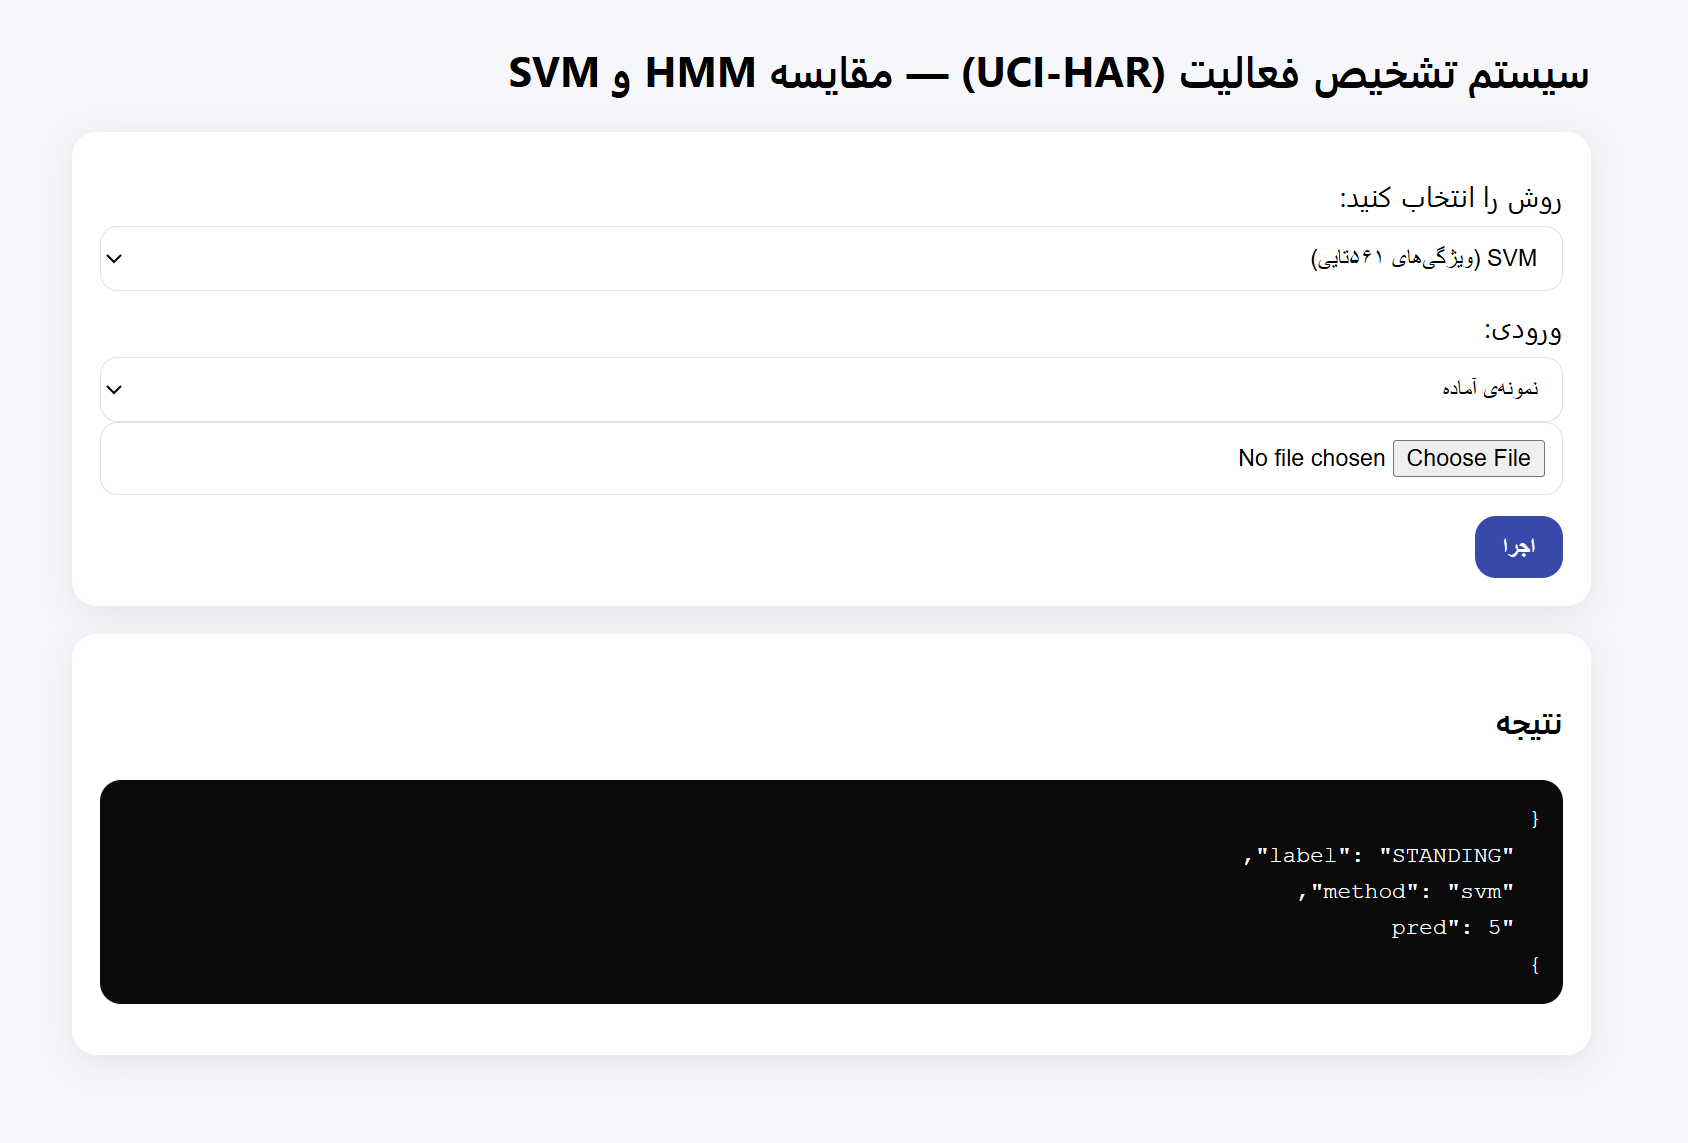

## خروجی برای روش RF

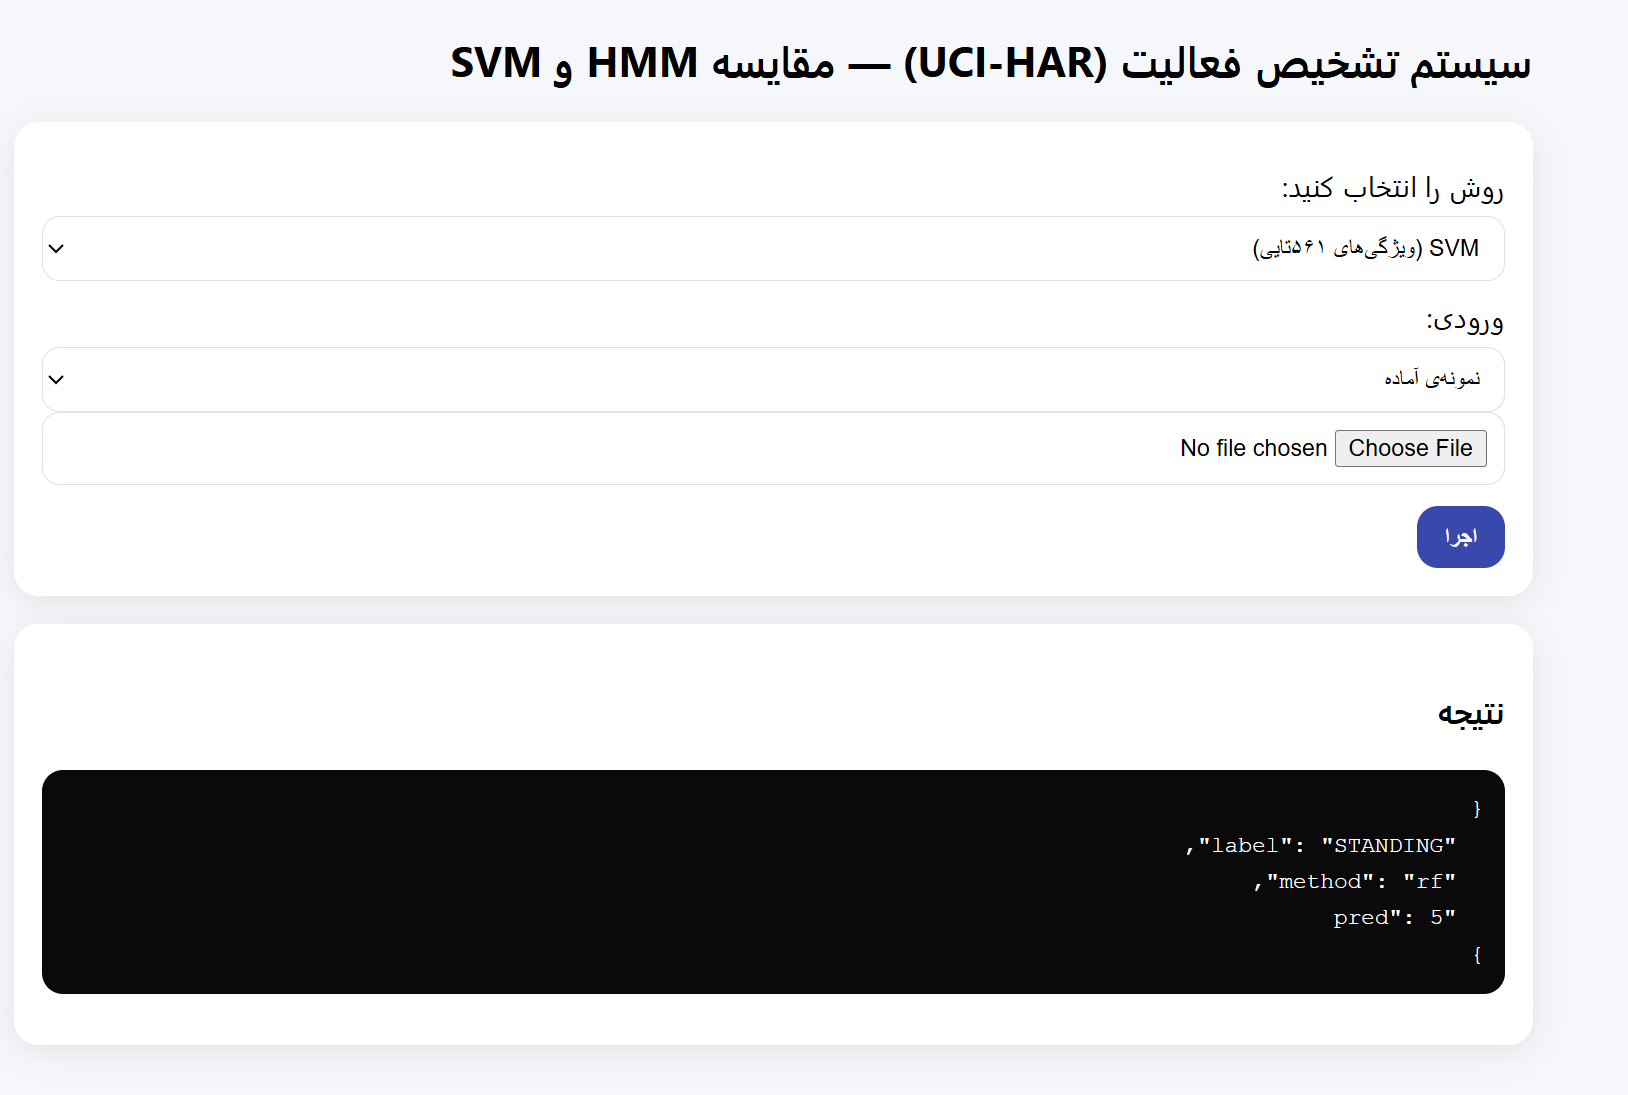

## خروجی روش HMM

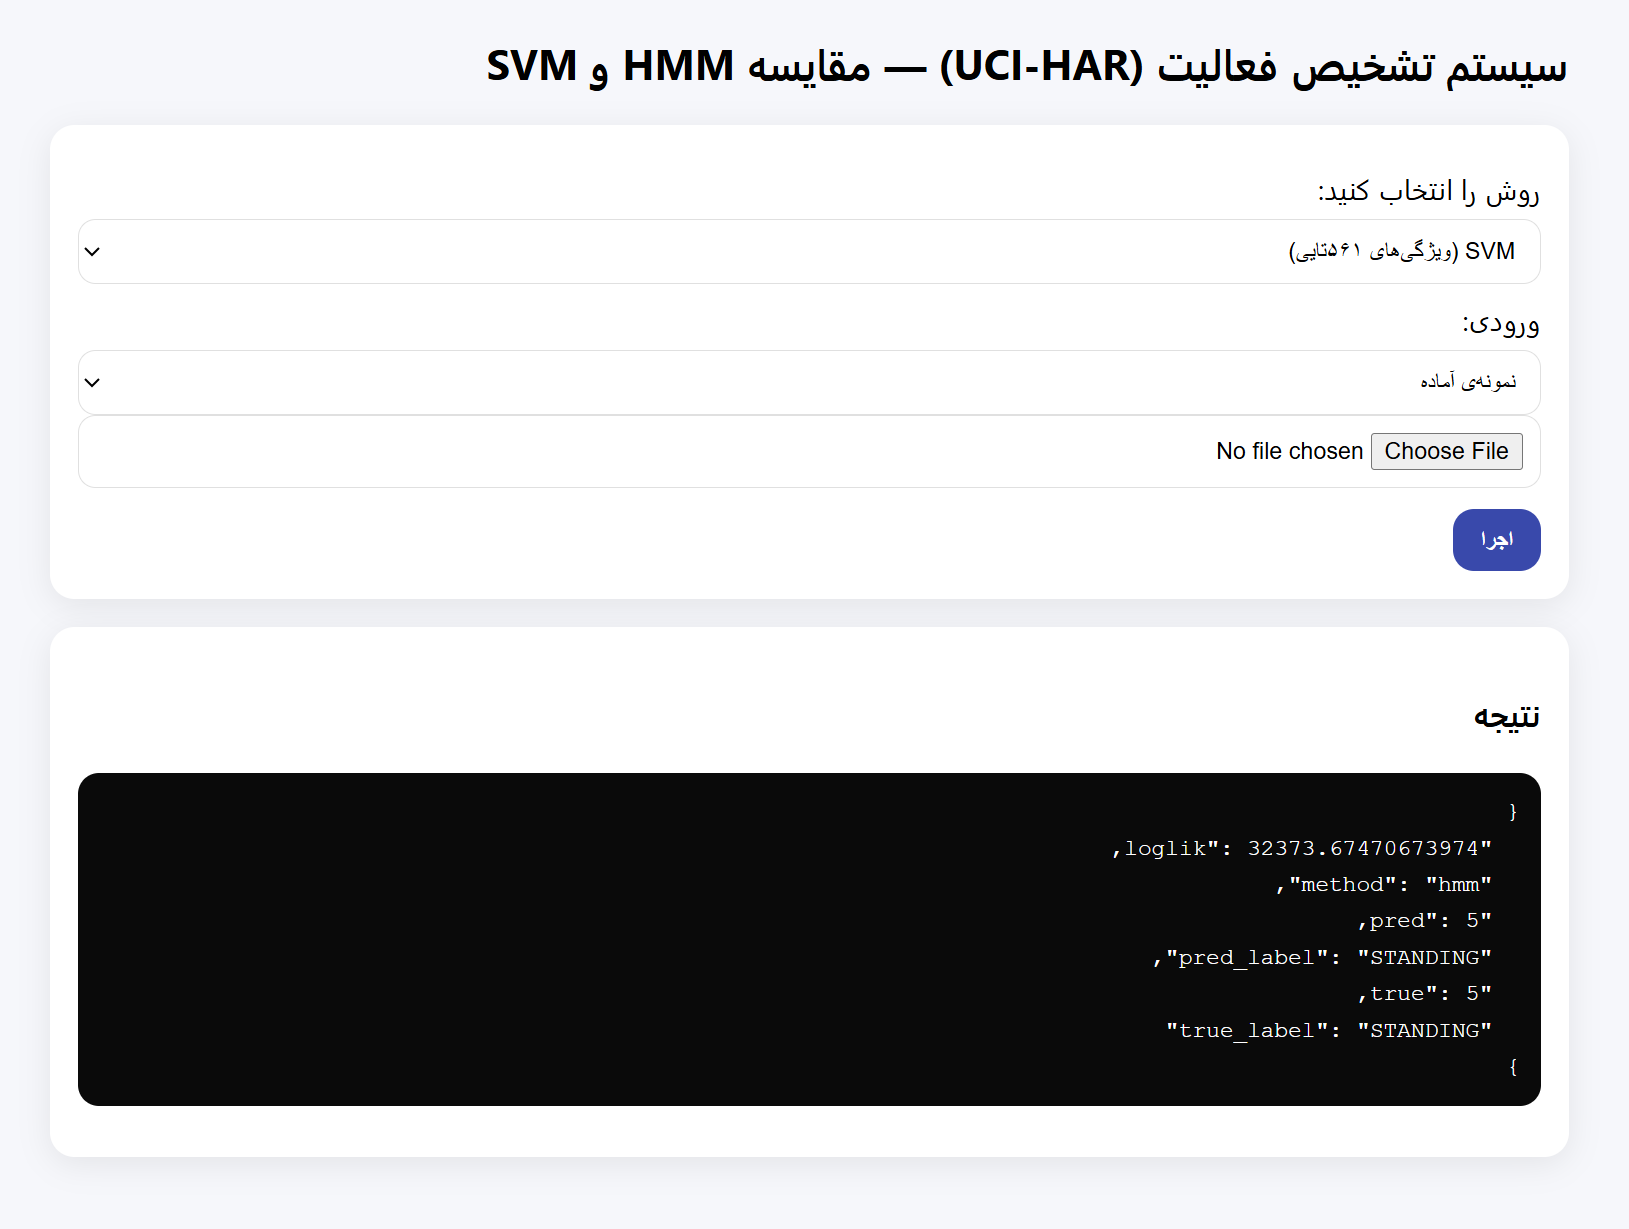